# Разделение на два канала

In [ ]:
import subprocess
import wave
import numpy as np
from pathlib import Path

def convert_to_pcm(input_file, output_file):
    """
    Конвертирует WAV-файл (например A-law, μ-law и т.д.) в обычный PCM WAV через FFmpeg.
    """
    print(f"Конвертация {input_file} → {output_file}")
    cmd = [
        "ffmpeg",
        "-y",                    # перезаписывать без подтверждения
        "-i", input_file,
        "-acodec", "pcm_s16le",  # 16-битный PCM
        "-ar", "44100",          # частота дискретизации 44.1 кГц
        "-ac", "2",              # стерео
        output_file
    ]
    subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print("Конвертация завершена.")


def save_wav_channel(folder, wav, channel):
    """
    Извлекает один канал из WAV и сохраняет его в общую папку temp.
    """
    nch   = wav.getnchannels()
    depth = wav.getsampwidth()
    wav.setpos(0)
    sdata = wav.readframes(wav.getnframes())

    typ = {1: np.uint8, 2: np.int16, 4: np.int32}.get(depth)
    if not typ:
        raise ValueError(f"Глубина {depth} байт не поддерживается.")
    if channel >= nch:
        raise ValueError(f"Канал {channel+1} не существует. Всего каналов: {nch}")

    print(f"Извлекаем канал {channel+1} из {nch}, {depth*8}-бит")

    data = np.frombuffer(sdata, dtype=typ)
    ch_data = data[channel::nch]

    out_path = Path(folder) / f"speaker{channel+1}.wav"

    outwav = wave.open(str(out_path), 'wb')
    outwav.setparams((1, depth, wav.getframerate(), 0, 'NONE', 'not compressed'))
    outwav.writeframes(ch_data.tobytes())
    outwav.close()

    print(f"Канал {channel+1} сохранён: {out_path}")


# === Основной блок ===
input_file = 'YOUR-FILE_test.wav'
base_name = Path(input_file).stem

main_folder = Path.cwd() / base_name
main_folder.mkdir(exist_ok=True)

temp_folder = main_folder / "temp"
temp_folder.mkdir(parents=True, exist_ok=True)

print(f"Рабочая папка: {temp_folder}")

pcm_file = temp_folder / f"{base_name}_pcm.wav"

# Конвертация в PCM
if not pcm_file.exists():
    convert_to_pcm(input_file, str(pcm_file))

# Извлечение каналов
wav = wave.open(str(pcm_file), 'rb')
for ch in range(wav.getnchannels()):
    save_wav_channel(temp_folder, wav, ch)
wav.close()

print(f"\nГотово! Все файлы сохранены в папке:\n{temp_folder}")


Рабочая папка: c:\Users\administrator\Desktop\diarization\test3\temp
Извлекаем канал 1 из 2, 16-бит
Канал 1 сохранён: c:\Users\administrator\Desktop\diarization\test3\temp\speaker1.wav
Извлекаем канал 2 из 2, 16-бит
Канал 2 сохранён: c:\Users\administrator\Desktop\diarization\test3\temp\speaker2.wav

Готово! Все файлы сохранены в папке:
c:\Users\administrator\Desktop\diarization\test3\temp


# Получение спектограммы двух аудиофайлов (голосовой активности)


Сегменты для файла ./test3/temp/speaker1.wav:
Segment 1: 5.64s - 5.90s
Segment 2: 6.22s - 6.43s
Segment 3: 6.48s - 6.66s
Segment 4: 7.64s - 7.67s
Segment 5: 19.70s - 20.00s
Segment 6: 20.05s - 20.36s
Segment 7: 20.45s - 20.63s
Segment 8: 20.64s - 20.76s
Segment 9: 20.92s - 20.98s
Segment 10: 21.05s - 21.10s
Segment 11: 28.40s - 28.46s
Segment 12: 28.55s - 28.63s
Segment 13: 28.71s - 28.77s
Segment 14: 29.68s - 29.78s
Segment 15: 29.90s - 29.99s
Segment 16: 30.02s - 30.08s
Segment 17: 30.52s - 30.81s
Segment 18: 32.54s - 32.60s
Segment 19: 35.36s - 35.94s
Segment 20: 36.54s - 36.79s
Segment 21: 36.82s - 36.93s
Segment 22: 37.00s - 37.11s
Segment 23: 37.18s - 37.48s
Segment 24: 37.67s - 37.74s
Segment 25: 37.78s - 37.85s
Segment 26: 37.98s - 38.05s
Segment 27: 38.07s - 38.19s
Segment 28: 38.23s - 38.51s
Segment 29: 38.53s - 38.60s
Segment 30: 39.21s - 39.30s
Segment 31: 39.44s - 39.53s
Segment 32: 41.37s - 41.46s
Segment 33: 41.53s - 41.61s
Segment 34: 41.68s - 41.82s
Segment 35: 41.87s

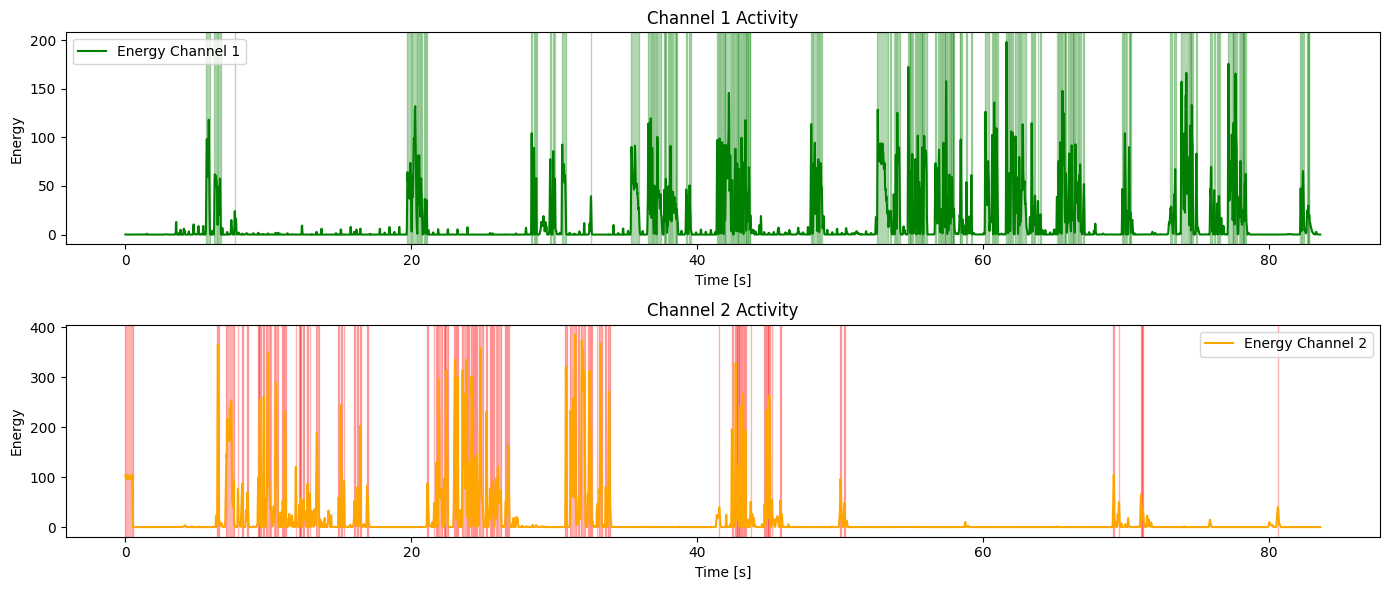

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def get_segments(filename, frame_length=2048, hop_length=512, threshold_ratio=0.1):
    """
    Определяет интервалы активности речи на аудио по уровню энергии.
    Возвращает: (y, sr, energy, times, segments)
    """
    y, sr = librosa.load(filename, sr=None)
    
    energy = np.array([
        np.sum(np.abs(y[i:i+frame_length]**2))
        for i in range(0, len(y), hop_length)
    ])
    
    threshold = np.max(energy) * threshold_ratio
    mask = energy > threshold

    times = np.arange(len(energy)) * hop_length / sr
    
    segments = []
    start = None
    for t, m in zip(times, mask):
        if m and start is None:
            start = t
        elif not m and start is not None:
            segments.append((start, t))
            start = None
    if start is not None:
        segments.append((start, times[-1]))
    
    return y, sr, energy, times, segments


def plot_and_print_segments(file, color='green', label='Channel'):
    """
    Печатает сегменты и возвращает их для дальнейшего анализа.
    """
    y, sr, energy, times, segments = get_segments(file)
    
    print(f"\nСегменты для файла {file}:")
    for i, (start, end) in enumerate(segments):
        print(f"Segment {i+1}: {start:.2f}s - {end:.2f}s")
    
    return y, sr, energy, times, segments


def segments_are_similar(segments1, segments2, tolerance=0.05):
    """
    Проверяет, совпадают ли интервалы активности двух файлов.
    tolerance — допустимая разница (в секундах).
    """
    if len(segments1) != len(segments2):
        return False

    for (s1, e1), (s2, e2) in zip(segments1, segments2):
        if abs(s1 - s2) > tolerance or abs(e1 - e2) > tolerance:
            return False
    return True


# === Основной блок ===
file1 = "your/to/path/speaker1.wav"
file2 = "your/to/path/speaker2.wav"

y1, sr1, energy1, times1, segments1 = plot_and_print_segments(file1, color='green', label='Channel 1')
y2, sr2, energy2, times2, segments2 = plot_and_print_segments(file2, color='red', label='Channel 2')

# === Проверка на идентичность сегментов ===
if segments_are_similar(segments1, segments2):
    print("\n⚠️  ПРЕДУПРЕЖДЕНИЕ: Сегменты активности полностью совпадают! "
          "Возможно, это не два независимых канала, а монофайл, разделённый на 2 одинаковые дорожки.")
else:
    print("\n✅ Каналы различаются — это действительно стерео (разные спикеры).")

# === Визуализация ===
plt.figure(figsize=(14,6))

plt.subplot(2,1,1)
plt.plot(times1, energy1, label='Energy Channel 1', color='green')
for start, end in segments1:
    plt.axvspan(start, end, color='green', alpha=0.3)
plt.title('Channel 1 Activity')
plt.xlabel('Time [s]')
plt.ylabel('Energy')
plt.legend()

plt.subplot(2,1,2)
plt.plot(times2, energy2, label='Energy Channel 2', color='orange')
for start, end in segments2:
    plt.axvspan(start, end, color='red', alpha=0.3)
plt.title('Channel 2 Activity')
plt.xlabel('Time [s]')
plt.ylabel('Energy')
plt.legend()

plt.tight_layout()
plt.show()


# Получение текста и временных меток

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration, pipeline
import torch
import torchaudio
import os
import numpy as np
import re
import difflib

# === Параметры ===
model_name = "./models/whisper-large-v3-turbo"
file1 = "your/to/path/speaker1.wav"
file2 = "your/to/path/speaker1.wav"

# === Проверка CUDA ===
device = 0 if torch.cuda.is_available() else -1
print(f"⚙️ Device: {'CUDA' if device == 0 else 'CPU'}")

# === Загрузка модели ===
model = WhisperForConditionalGeneration.from_pretrained(model_name).to("cuda" if device == 0 else "cpu")
processor = WhisperProcessor.from_pretrained(model_name)

# === Создание пайплайна ===
asr = pipeline(
    task="automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    device=device,
    ignore_warning=True,
)

# === Проверка: одинаковые ли каналы ===
def is_mono_audio(file1, file2, tolerance=1e-3):
    """Проверяет, одинаковы ли два аудиофайла."""
    y1, sr1 = torchaudio.load(file1)
    y2, sr2 = torchaudio.load(file2)
    if sr1 != sr2:
        return False

    min_len = min(y1.shape[-1], y2.shape[-1])
    y1, y2 = y1[..., :min_len], y2[..., :min_len]
    y1 = y1.mean(dim=0)
    y2 = y2.mean(dim=0)

    corr = torch.corrcoef(torch.stack([y1, y2]))[0, 1].item()
    diff = torch.mean(torch.abs(y1 - y2)).item()

    print(f"🔍 Проверка каналов: корреляция={corr:.4f}, среднее отклонение={diff:.6f}")
    return corr > 0.995 and diff < tolerance


# === Распознавание с таймкодами ===
def transcribe_with_timestamps(audio_path, speaker_name):
    waveform, sr = torchaudio.load(audio_path)
    if sr != 16000:
        waveform = torchaudio.functional.resample(waveform, sr, 16000)
        sr = 16000
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    temp_path = f"temp_{speaker_name}.wav"
    torchaudio.save(temp_path, waveform, sr)

    print(f"\n🎙 Распознавание {speaker_name}...")
    result = asr(temp_path, chunk_length_s=30, return_timestamps=True)

    segments = []
    for chunk in result["chunks"]:
        start, end = chunk["timestamp"]
        start = start if start is not None else 0.0
        end = end if end is not None else start + 0.5
        text = chunk["text"].strip()
        if text:
            segments.append((start, end, speaker_name, text))

    os.remove(temp_path)
    return segments


# === Объединение сегментов и фильтрация ===
def merge_dialog_segments(segments1, segments2, overlap_tolerance=1.0):
    """
    Объединяет сегменты двух спикеров в единый диалог:
    - сохраняет хронологию
    - корректно чередует реплики
    - удаляет шум, дубли и инородные фразы
    """
    merged = sorted(segments1 + segments2, key=lambda x: x[0])
    cleaned = []

    def is_foreign_or_gibberish(text):
        # Если слишком много латиницы, символов с диакритикой, повторов или "бреда"
        latin_ratio = len(re.findall(r"[A-Za-zÀ-ž]", text)) / max(1, len(text))
        repeat_ratio = len(re.findall(r"(\b\w+\b)(?:\s+\1){3,}", text)) > 0
        # Если доля латиницы > 0.3 или слишком много повторов — удалить
        return latin_ratio > 0.3 or repeat_ratio

    for seg in merged:
        start, end, speaker, text = seg

        # 1️⃣ — пропускаем слишком короткие фразы (шум, звонки и т.п.)
        if len(text.split()) < 3 and (end - start) < 1.5:
            continue

        # 2️⃣ — фильтруем иностранные или бессмысленные вставки
        if is_foreign_or_gibberish(text):
            continue

        # 3️⃣ — объединяем пересекающиеся сегменты одного спикера
        if cleaned and start - cleaned[-1][1] < overlap_tolerance:
            if speaker == cleaned[-1][2]:
                cleaned[-1] = (
                    cleaned[-1][0],
                    max(end, cleaned[-1][1]),
                    speaker,
                    cleaned[-1][3] + " " + text,
                )
                continue

        # 4️⃣ — убираем дублирующийся текст
        if cleaned:
            similarity = difflib.SequenceMatcher(None, cleaned[-1][3], text).ratio()
            if similarity > 0.9:
                continue

        cleaned.append((start, end, speaker, text))

    return cleaned

# === Основная логика ===
if is_mono_audio(file1, file2):
    print("\n⚠️ Обнаружено моноаудио — каналы идентичны. Транскрибируется только один канал.")
    all_segments = transcribe_with_timestamps(file1, "Speaker")
else:
    segments1 = transcribe_with_timestamps(file1, "Speaker 1")
    segments2 = transcribe_with_timestamps(file2, "Speaker 2")
    all_segments = merge_dialog_segments(segments1, segments2)

output_dir = os.path.dirname(file1)
output_path = os.path.join(output_dir, 'dialogue.txt')

# === Сохранение результата ===
with open(output_path, "w", encoding="utf-8") as f:
    for start, end, speaker, text in all_segments:
        line = f"{speaker}: {text}"
        print(line)
        f.write(line + "\n")

print(f"\n✅ Диалог с временными метками сохранён в {output_path}")
